In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from IPython import display
import random
#import gym
import time
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [43]:
M=128;
dt=1.0/100.0;
T=730;
it=10*730;

w=1.0/15.0;
gamma=.019;
eta=.03;
theta=.56;
A0par=1.0/30.0;

B=np.zeros((M,M));
A0=A0par*np.ones((M,M));
n=np.zeros((M,M));
print(np.int(1.0))

1


In [48]:
def update_system(A0,B,n,dt,gamma,eta,theta,w):
    ntemp=np.zeros(n.shape);
    C=np.zeros(n.shape);
    M=n.shape[0]
    A=A0+B;
    
#     at = np.zeros((M,M))
#     at[:-1, :] += A[1:, :]
#     at[1:, :] += A[:-1, :]
#     at[:, :-1] += A[:, 1:]
#     at[:, 1:] += A[:, :-1]
    
#     tv = np.reshape((n>0), )
    
    for i in range(M):
        for j in range(M):
            
            #loop through criminals and commit crimes or move
            for l in range(np.int(n[i,j])):
                if((1.0-np.exp(-A[i,j]*dt))>np.random.rand()):
                    ntemp[i,j]=ntemp[i,j]-1;
                    C[i,j]=C[i,j]+1;
                else:
                    temp=A[min(i+1,M-1),j]+A[max(i-1,0),j]+A[i,min(j+1,M-1)]+A[i,max(j-1,0)];
                    u=np.random.rand();
                    p1=A[min(i+1,M-1),j]/temp;
                    p2=p1+A[max(i-1,0),j]/temp;
                    p3=p2+A[i,min(j+1,M-1)]/temp;
                    p4=p3+A[i,max(j-1,0)]/temp;
                    if(u<p1):
                        it=min(i+1,M-1);
                        jt=j;
                    if((u<p2) and (u>=p1)):
                        it=max(i-1,0);
                        jt=j;
                    if((u<p3) and (u>=p2)):
                        it=i;
                        jt=min(j+1,M-1);
                    if((u<p4) and (u>=p3)):
                        it=i;
                        jt=max(j-1,0);
                        
                    ntemp[it,jt]=ntemp[it,jt]+1;
                    ntemp[i,j]=ntemp[i,j]-1;
    # new criminal count is old one plus those that moved to minus
    # those that moved from or commited crimes
            
    n=n+ntemp;

    # also add criminals to system
    n += (1-np.exp(-gamma*dt))>np.random.rand(M, M)
    #for i in range(M):
    #   for j in range(M):
    #        if((1-np.exp(-gamma*dt))>np.random.rand()):
    #            n[i,j]=n[i,j]+1;
    
    

    #update attractiveness based upon recent crimes
    Btemp=np.copy(B)
    for i in range(M):
        for j in range(M):
            dB=B[i,j]*(1-eta)+(eta/4)*(B[min(i+1,M-1),j]+B[max(i-1,0),j]+B[i,min(j+1,M-1)]+B[i,max(j-1,0)])
            Btemp[i,j]=theta*C[i,j]+(1.0-w*dt)*dB
 
    bt = np.zeros((M,M))
    bt[:-1, :] += B[1:, :]
    bt[1:, :] += B[:-1, :]
    bt[:, :-1] += B[:, 1:]
    bt[:, 1:] += B[:, :-1]
    
    bt[0, :] += B[0, :]
    bt[-1, :] += B[-1, :]
    bt[:, 0] += B[:, 0]
    bt[:, -1] += B[:, -1]
    dB=B*(1-eta)+(eta/4)*bt
    B2=theta*C+(1.0-w*dt)*dB
    
    B = np.copy(Btemp)
    diff = np.abs(B-B2).sum()
    

    return C,B,n,diff

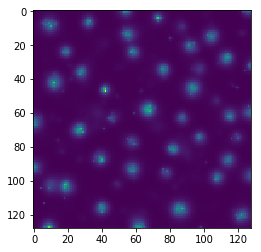

145.21337699890137
5.204170427930421e-18
1300


KeyboardInterrupt: 

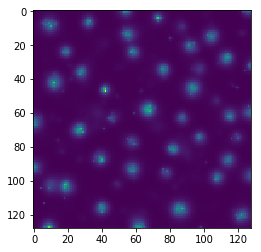

In [49]:
start = time.time()
for k in range(it):
    C,B,n,diff=update_system(A0,B,n,dt,gamma,eta,theta,w)
    if k % 100 == 0:
        plt.clf()
        plt.imshow(B)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        end = time.time()
        print((end-start))
        print(diff)
        print(k)

In [23]:
a = np.random.randn(5,5)
print(a)
print(a[:-1, :])

[[ 0.18841728  0.42358523  1.47926169  0.30751467 -0.91954548]
 [-0.84448856  1.95332357  0.95011144  1.03936791 -1.82039748]
 [ 1.68410319  0.00815852  1.27665424  0.59801078  0.23685533]
 [-1.21054727  1.4345218  -1.93555674 -0.44851038  0.60605394]
 [-0.43509721  0.81980458  0.06158464  0.3120098   1.87275736]]
[[ 0.18841728  0.42358523  1.47926169  0.30751467 -0.91954548]
 [-0.84448856  1.95332357  0.95011144  1.03936791 -1.82039748]
 [ 1.68410319  0.00815852  1.27665424  0.59801078  0.23685533]
 [-1.21054727  1.4345218  -1.93555674 -0.44851038  0.60605394]]
